# Part 3: Regression for joint angles

In [67]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
from scipy.ndimage import convolve1d
from scipy.signal import butter, sosfiltfilt, welch, iirnotch, filtfilt
import pandas as pd
import os
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler

sns.set()


## DATA visualization

In [68]:
EMG_file_name_train = './Dataset1_DB8/s1/S1_E1_A1.mat'
EMG_file_name_val = './Dataset1_DB8/s1/S1_E1_A2.mat'
EMG_file_name_test = './Dataset1_DB8/s1/S1_E1_A3.mat'
data_train = loadmat(EMG_file_name_train)
data_val = loadmat(EMG_file_name_val)
data_test = loadmat(EMG_file_name_test)
print("Dataset variables:")
for key in data_train.keys():
    if not key.startswith("__"):
        print(key)

Dataset variables:
subject
exercise
emg
acc
gyro
mag
glove
stimulus
repetition
restimulus
rerepetition


In [69]:
emg_data_train = data_train["emg"]
emg_data_test = data_test["emg"]
emg_data_val = data_val["emg"]

# Print information about the extracted data
print(f"EMG data dimension: {emg_data_train.shape}")
print(f"EMG data type: {type(emg_data_train)}\n")



EMG data dimension: (2292526, 16)
EMG data type: <class 'numpy.ndarray'>



## DATA preprocessing

In [70]:
# Use the joint angles 3,6,8,11,14
glove_data_index_train = data_train["glove"][:, [3, 6, 8, 11, 14]]
glove_data_index_test = data_test["glove"][:, [3, 6, 8, 11, 14]]
glove_data_index_val = data_val["glove"][:, [3, 6, 8, 11, 14]]

print("Glove data dimension: {}".format(glove_data_index_train.shape))
print("Glove data type: {}".format(type(glove_data_index_train)))


Glove data dimension: (2292526, 5)
Glove data type: <class 'numpy.ndarray'>


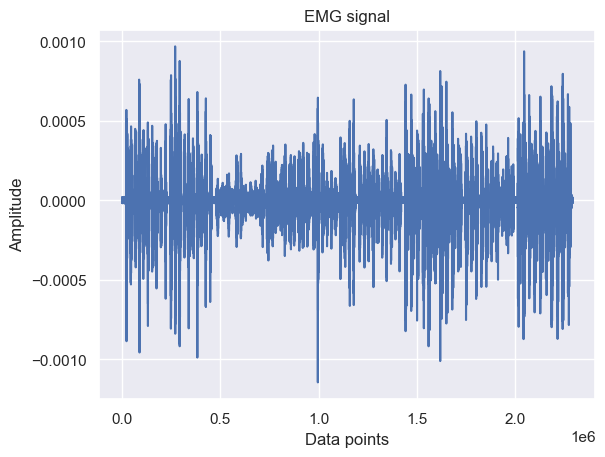

In [71]:
# Plot first channel to get a sense of the data
plt.close("all")
fig, ax = plt.subplots()


ax.plot(emg_data_train[:, 5])
ax.set_title("EMG signal")
ax.set_xlabel("Data points")
ax.set_ylabel("Amplitude")

plt.show()

We can observe when the channel detects muscle signals. Let's evaluate the signal quality to determine the appropriate signal processing techniques.

Text(0.5, 1.0, 'Power Spectral Density plot in Log scale')

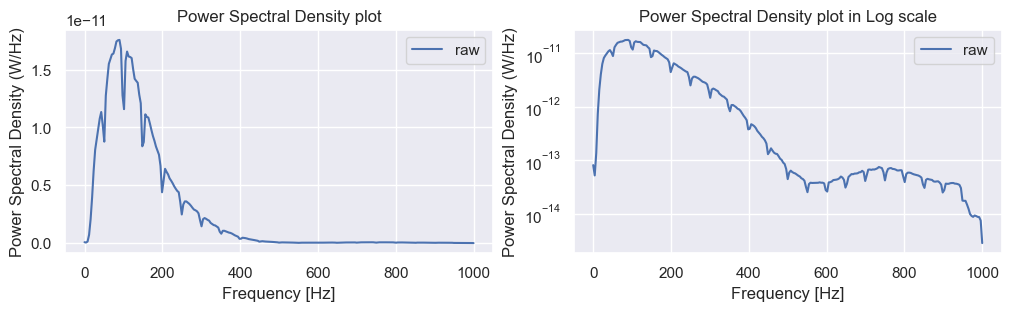

In [72]:
#Use Welch's method for power spectral density estimation, it reduces the variance of the estimate.
freqs_pre, Pxx_pre = welch(emg_data_train[:, 8], fs=2000, nperseg=512)

fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 3))
ax[0].plot(freqs_pre, Pxx_pre, label="raw")
ax[0].legend()
ax[0].set_xlabel("Frequency [Hz]")
ax[0].set_ylabel("Power Spectral Density (W/Hz)")
ax[0].set_title("Power Spectral Density plot")

ax[1].semilogy(freqs_pre, Pxx_pre, label="raw")
ax[1].legend()
ax[1].set_xlabel("Frequency [Hz]")
ax[1].set_ylabel("Power Spectral Density (W/Hz)")
ax[1].set_title("Power Spectral Density plot in Log scale")

Let's proceed to the powerline filtering and passband filtering.

In [73]:
def apply_notch_filter(signal, fs, freq=50, quality_factor=30):
    """
    Apply a Notch filter at a specified frequency to remove powerline noise.
    Args:
        signal: The input EMG signal (1D array).
        fs: Sampling frequency in Hz.
        freq: Frequency to remove (default: 50 Hz).
        quality_factor: Controls the bandwidth of the notch filter.
    Returns:
        Filtered signal.
    """
    # Design the Notch filter
    b_notch, a_notch = iirnotch(freq, quality_factor, fs)

    # Apply the filter using filtfilt for zero phase distortion
    filtered_signal = filtfilt(b_notch, a_notch, signal)
    return filtered_signal


def apply_bandpass_filter(signal, fs, lowcut=20, highcut=450, order=4):
    """
    Apply a bandpass filter to retain relevant EMG frequencies.
    Args:
        signal: The input EMG signal (1D array).
        fs: Sampling frequency in Hz.
        lowcut: Lower frequency cutoff (default: 20 Hz).
        highcut: Upper frequency cutoff (default: 450 Hz).
        order: Order of the filter.
    Returns:
        Filtered signal.
    """
    sos_bandpass = butter(order, [lowcut, highcut], btype="band", fs=fs, output="sos")
    filtered_signal = sosfiltfilt(sos_bandpass, signal)
    return filtered_signal

def process_all_channels(emg_data, fs):
    """
    Generalized function to filter EMG signals and compute PSD for all channels.

    Parameters:
        emg_data (ndarray): Multi-channel EMG data (shape: [n_samples, n_channels]).
        fs (int): Sampling frequency (Hz).

    Returns:
        filtered_emg_data (ndarray): Filtered EMG data (same shape as input).
    """
    print(emg_data.shape)
    n_channels = emg_data.shape[1]
    filtered_emg_data = np.zeros_like(emg_data)


    for i in range(n_channels):
        emg_channel = emg_data[:, i]
        emg_filtered_notch = apply_notch_filter(emg_channel, fs, freq=50, quality_factor=30)
        emg_filtered = apply_bandpass_filter(emg_filtered_notch, fs, lowcut=5, highcut=500)

        filtered_emg_data[:, i] = emg_filtered

    return filtered_emg_data


fs = 2000


filtered_emg_data_train = process_all_channels(emg_data_train, fs)
filtered_emg_data_test = process_all_channels(emg_data_test, fs)
filtered_emg_data_val = process_all_channels(emg_data_val, fs)


(2292526, 16)
(529099, 16)
(2313470, 16)


/var/folders/kd/rc_r8j55289115b7qptd65yh0000gq/T/ipykernel_873/3051439251.py:25: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/Users/Romain/opt/anaconda3/envs/bio482/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


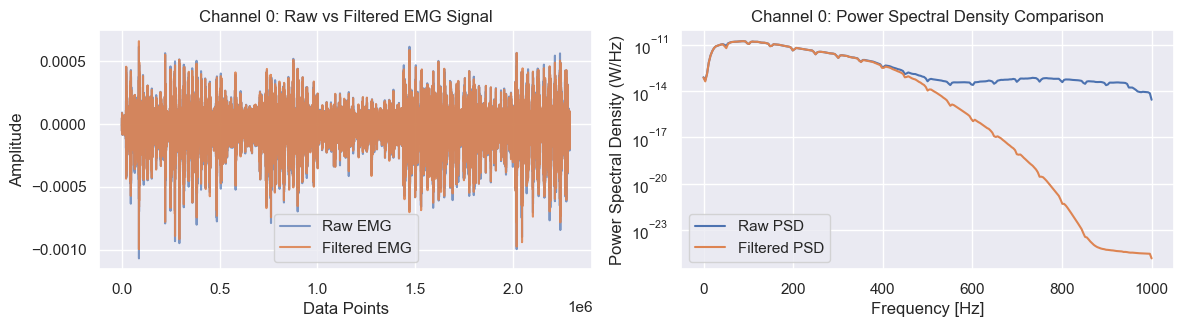

In [74]:
channel_0_raw = emg_data_train[:, 8]
channel_0_filtered = filtered_emg_data_train[:, 8]

freqs_raw, Pxx_raw = welch(channel_0_raw, fs=fs, nperseg=512)
freqs_filtered, Pxx_filtered = welch(channel_0_filtered, fs=fs, nperseg=512)

plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.plot(channel_0_raw, label="Raw EMG", alpha=0.7)
plt.plot(channel_0_filtered, label="Filtered EMG", alpha=0.9)
plt.title("Channel 0: Raw vs Filtered EMG Signal")
plt.xlabel("Data Points")
plt.ylabel("Amplitude")
plt.legend()

plt.subplot(2, 2, 2)
plt.semilogy(freqs_raw, Pxx_raw, label="Raw PSD")
plt.semilogy(freqs_filtered, Pxx_filtered, label="Filtered PSD")
plt.title("Channel 0: Power Spectral Density Comparison")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Power Spectral Density (W/Hz)")
plt.legend()

plt.tight_layout()
plt.show()

### Enveloping

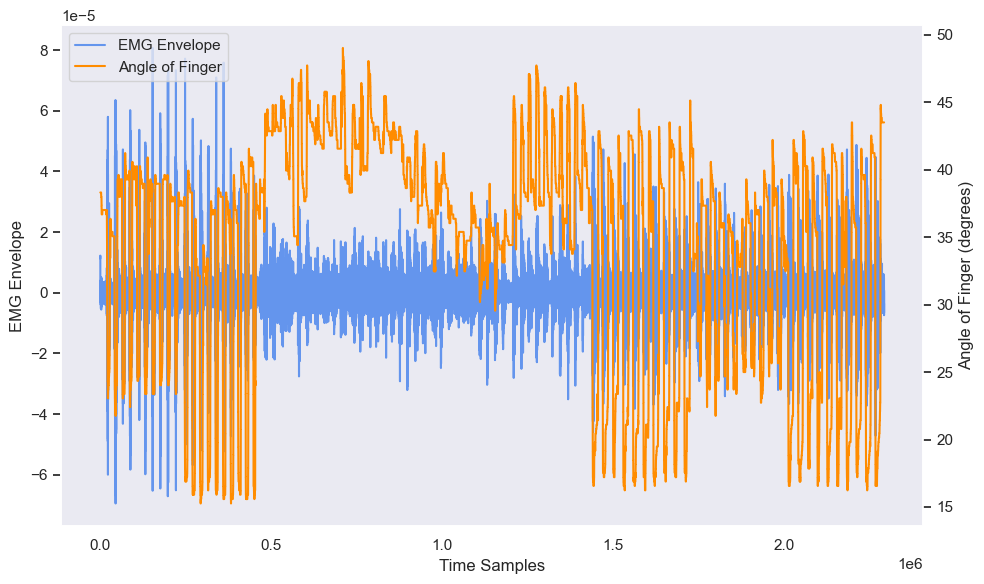

In [75]:
emg_data_train = filtered_emg_data_train
glove_data_train = glove_data_index_train
emg_data_test = filtered_emg_data_test
glove_data_test = glove_data_index_test
emg_data_val = filtered_emg_data_val
glove_data_val = glove_data_index_val

mov_mean_size = 50
mov_mean_weights = np.ones(mov_mean_size) / mov_mean_size

# Create EMG envelopes using the moving average filter (convolution) for the 3 datasets to have the same preprossed step
EMG_envelopes_train = convolve1d(emg_data_train, weights=mov_mean_weights, axis=0)
EMG_envelopes_test = convolve1d(emg_data_test, weights=mov_mean_weights, axis=0)
EMG_envelopes_val = convolve1d(emg_data_val, weights=mov_mean_weights, axis=0)


fig, ax = plt.subplots(figsize=(10, 6))


ax.plot(EMG_envelopes_train[:, 0], color='cornflowerblue', label="EMG Envelope")
ax.set_xlabel("Time Samples")
ax.set_ylabel("EMG Envelope")
ax.grid(False)

finger_angle_ax = ax.twinx()


finger_angle_ax.plot(glove_data_train[:, 0], color="darkorange", label="Angle of Finger")
finger_angle_ax.set_ylabel("Angle of Finger (degrees)")
finger_angle_ax.grid(False)


emg_handles, emg_labels = ax.get_legend_handles_labels()
finger_angle_handles, finger_angle_labels = finger_angle_ax.get_legend_handles_labels()


combined_handles = emg_handles + finger_angle_handles
combined_labels = emg_labels + finger_angle_labels

ax.legend(combined_handles, combined_labels, loc='upper left')

plt.tight_layout()


plt.show()


### Sliding window

In [76]:
fs = 2000  # [Hz]
emg_window_length_sec = 0.128  # [s]
incremental_window_length_sec = 0.050  # [s]

In [77]:
def extract_time_windows_regression(EMG: np.ndarray, Label: np.ndarray, fs: int, win_len: int, step: int):
    """
    This function is defined to perform an overlapping sliding window
    :param EMG: Numpy array containing the data
    :param Label: Numpy array containing the targets
    :param fs: the sampling frequency of the signal
    :param win_len: The size of the windows (in seconds)
    :param step: The step size between windows (in seconds)

    :return: A Numpy array containing the windows
    :return: A Numpy array containing the targets aligned for each window
    :note: The lengths of both outputs are the same
    """

    n,m = EMG.shape
    win_len = int(win_len*fs)
    start_points = np.arange(0,n-win_len,int(step*fs))
    end_points = start_points + win_len

    EMG_windows = np.zeros((len(start_points),win_len,m))
    Labels_window = np.zeros((len(start_points),win_len,Label.shape[1]))
    for i in range(len(start_points)):
        EMG_windows[i,:,:] = EMG[start_points[i]:end_points[i],:]
        Labels_window[i,:,:] = Label[start_points[i]:end_points[i],:]


    return EMG_windows, Labels_window

In [78]:
# extract over lapping time windows on the whole dataset onto the three datasets
EMG_windows_train, Labels_windows_train = extract_time_windows_regression(EMG_envelopes_train, glove_data_index_train, fs, emg_window_length_sec, incremental_window_length_sec)
EMG_windows_test, Labels_windows_test = extract_time_windows_regression(EMG_envelopes_test, glove_data_index_test, fs, emg_window_length_sec, incremental_window_length_sec)
EMG_windows_val, Labels_windows_val = extract_time_windows_regression(EMG_envelopes_val, glove_data_index_val, fs, emg_window_length_sec, incremental_window_length_sec)

print(f"EMG train data shape: {EMG_windows_train.shape}, Train label shape: {Labels_windows_train.shape}")
print(f"EMG test data shape: {EMG_windows_test.shape}, Test label shape: {Labels_windows_test.shape}")
print(f"EMG validation data shape: {EMG_windows_val.shape}, Validation label shape: {Labels_windows_val.shape}")

EMG train data shape: (22923, 256, 16), Train label shape: (22923, 256, 5)
EMG test data shape: (5289, 256, 16), Test label shape: (5289, 256, 5)
EMG validation data shape: (23133, 256, 16), Validation label shape: (23133, 256, 5)


### Features extraction

In [79]:
def extract_features(EMG_windows: np.ndarray, Labels_windows: np.ndarray):
    """
    This function is defined to extract the mean and standard deviation of each window
    :param EMG_windows: A Numpy array containing the windows
    :return: A Numpy array containing the mean and standard deviation of each window and the mean of the labels window
    """
    EMG_mean = np.mean(EMG_windows, axis=1)
    EMG_std = np.std(EMG_windows, axis=1)
    EMG_max_amplitude = np.max(EMG_windows, axis=1)
    Labels_mean = np.mean(Labels_windows,axis=1)

    EMG_extracted_features = np.concatenate((EMG_mean, EMG_std, EMG_max_amplitude), axis=1)
    return EMG_extracted_features, Labels_mean

In [80]:
EMG_train_extracted_features, Labels_train_mean = extract_features(EMG_windows_train,Labels_windows_train)
EMG_test_extracted_features, Labels_test_mean = extract_features(EMG_windows_test,Labels_windows_test)
EMG_val_extracted_features, Labels_val_mean = extract_features(EMG_windows_val,Labels_windows_val)

print("EMG train extracted features shape: {}, Fingler labels feature shape:{}".format(EMG_train_extracted_features.shape, Labels_train_mean.shape))
print("EMG test extracted features shape: {}, Fingler labels feature shape:{}".format(EMG_test_extracted_features.shape, Labels_test_mean.shape))

EMG train extracted features shape: (22923, 48), Fingler labels feature shape:(22923, 5)
EMG test extracted features shape: (5289, 48), Fingler labels feature shape:(5289, 5)


48 columns correspond to 16 channels, with 3 features extracted per channel (3 * 16 = 48). Additionally, 5 joint angles are used for labels  (3, 6, 8, 11, and 14).

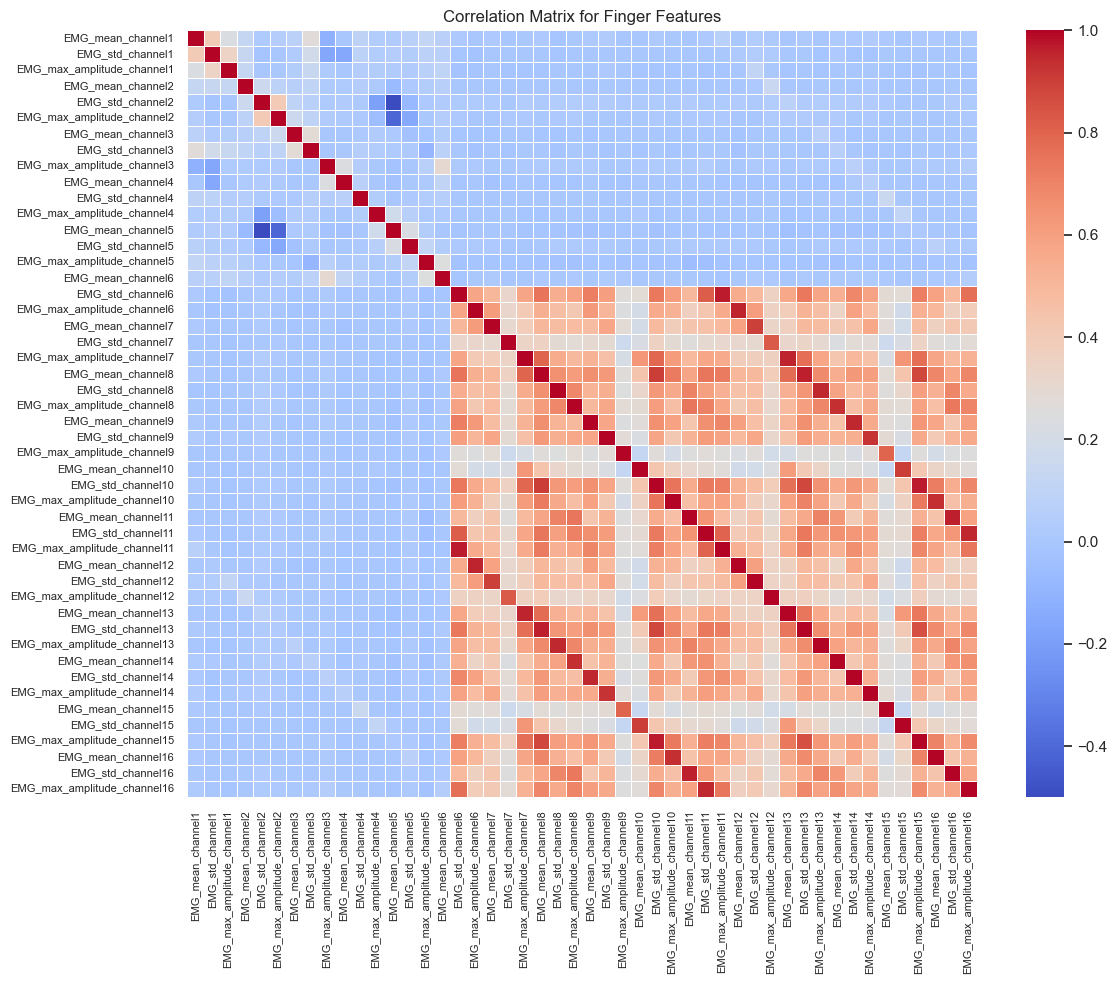

In [81]:
n_channels = 16
feature_types = ['EMG_mean', 'EMG_std', 'EMG_max_amplitude']
n_features_per_channel = len(feature_types)
n_features = n_channels * n_features_per_channel


# Normalize the features (EMG data) using StandardScaler
scaler = StandardScaler()
EMG_train_normalized = scaler.fit_transform(EMG_train_extracted_features)

# Generate feature names dynamically
feature_names = [
    f"{feature_type}_channel{channel+1}"
    for channel in range(n_channels)
    for feature_type in feature_types
]

# Convert the normalized features to a DataFrame for easier visualization
df_features = pd.DataFrame(EMG_train_normalized, columns=feature_names)

# Calculate the correlation matrix of the normalized features
correlation_matrix = df_features.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title(f"Correlation Matrix for Finger Features")


plt.xticks(ticks=np.arange(len(feature_names)) + 0.5, labels=feature_names, rotation=90, fontsize=8)
plt.yticks(ticks=np.arange(len(feature_names)) + 0.5, labels=feature_names, rotation=0, fontsize=8)


plt.tight_layout()
plt.show()


### Regression

Data normalization, whether performed channel by channel or all together, yields very similar results based on our experiments. Therefore, we opt for the simpler "all channels together" method for implementation.

Validation RMSE for each joint angle: [0.58667465 0.69106205 0.86502529 0.74257776 1.07984707]
Test RMSE for each joint angle: [0.52073693 0.61216831 0.81788188 0.64199971 0.9683775 ]
Test MAE for each joint angle: [0.39837104 0.40915142 0.43845723 0.36159351 0.73768642]


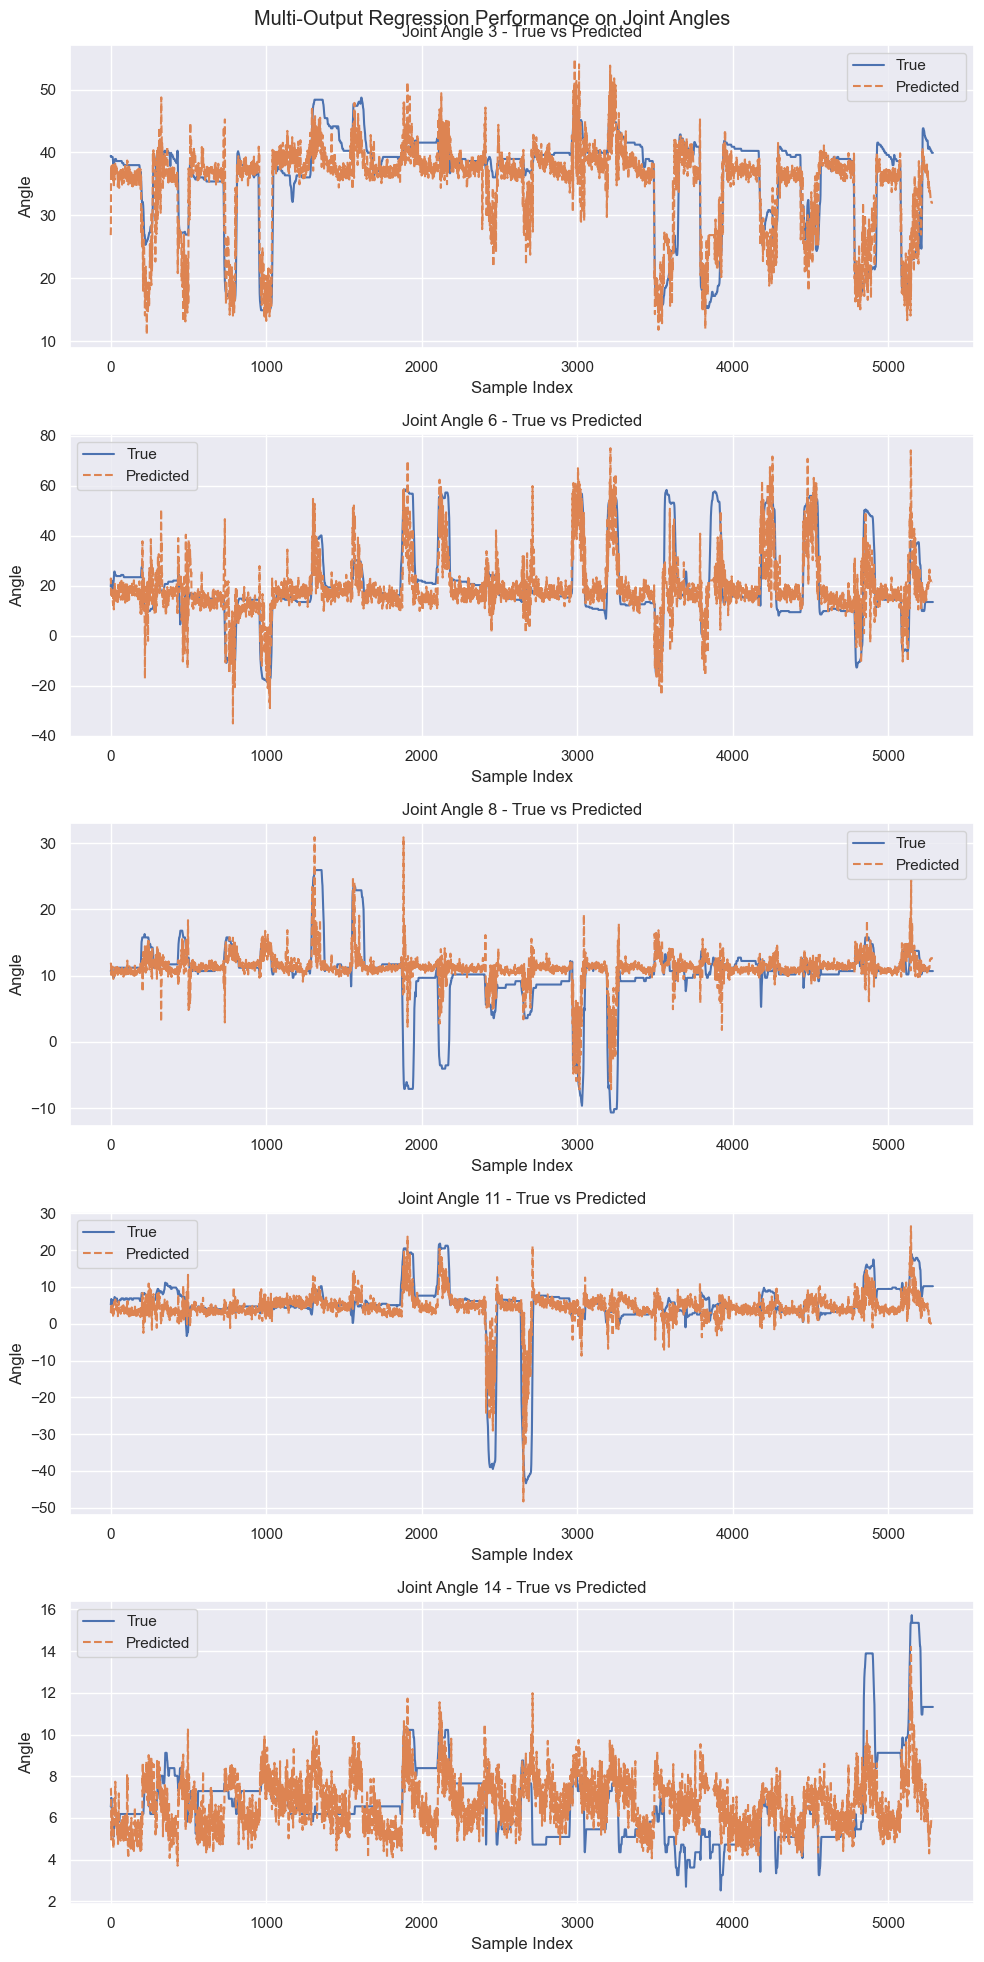

In [82]:
# Initialize the StandardScaler for normalization
scaler_emg = StandardScaler()
scaler_labels = StandardScaler()

# Normalize the EMG features (train, validation, and test)
EMG_train_scaled = scaler_emg.fit_transform(EMG_train_extracted_features)
EMG_val_scaled = scaler_emg.transform(EMG_val_extracted_features)
EMG_test_scaled = scaler_emg.transform(EMG_test_extracted_features)

# Normalize the labels (train, validation, and test)
Labels_train_scaled = scaler_labels.fit_transform(Labels_train_mean)
Labels_val_scaled = scaler_labels.transform(Labels_val_mean)
Labels_test_scaled = scaler_labels.transform(Labels_test_mean)

# Train Multi-Output Regressor with SVR
multi_output_regressor = MultiOutputRegressor(SVR())
multi_output_regressor.fit(EMG_train_scaled, Labels_train_scaled)

# Make predictions on the validation and test sets
y_pred_val_scaled = multi_output_regressor.predict(EMG_val_scaled)
y_pred_test_scaled = multi_output_regressor.predict(EMG_test_scaled)

# Calculate performance metrics (using scaled labels)
rmse_val = np.sqrt(mean_squared_error(Labels_val_scaled, y_pred_val_scaled, multioutput='raw_values'))
rmse_test = np.sqrt(mean_squared_error(Labels_test_scaled, y_pred_test_scaled, multioutput='raw_values'))
mae_test = mean_absolute_error(Labels_test_scaled, y_pred_test_scaled, multioutput='raw_values')

# Print performance metrics
print("Validation RMSE for each joint angle:", rmse_val)
print("Test RMSE for each joint angle:", rmse_test)
print("Test MAE for each joint angle:", mae_test)

# Visualize predictions vs. true labels for test set
plt.close("all")
fig, axes = plt.subplots(len(Labels_train_mean[0]), 1, figsize=(10, 20))  # One plot per joint angle
fig.tight_layout()
fig.subplots_adjust(top=0.95)
fig.suptitle("Multi-Output Regression Performance on Joint Angles")

# Plot each joint angle separately
joint_angles = {
    0: 3,
    1: 6,
    2: 8,
    3: 11,
    4: 14,
}
for i in range(len(Labels_train_mean[0])):
    # Inverse transform to get back to the original scale
    axes[i].plot(scaler_labels.inverse_transform(Labels_test_scaled)[:, i], label="True")
    axes[i].plot(scaler_labels.inverse_transform(y_pred_test_scaled)[:, i], linestyle="--", label="Predicted")
    axes[i].set_title(f"Joint Angle {joint_angles[i]} - True vs Predicted")
    axes[i].legend()
    axes[i].set_xlabel("Sample Index")
    axes[i].set_ylabel("Angle")
plt.tight_layout()
plt.show()


# Evaluation

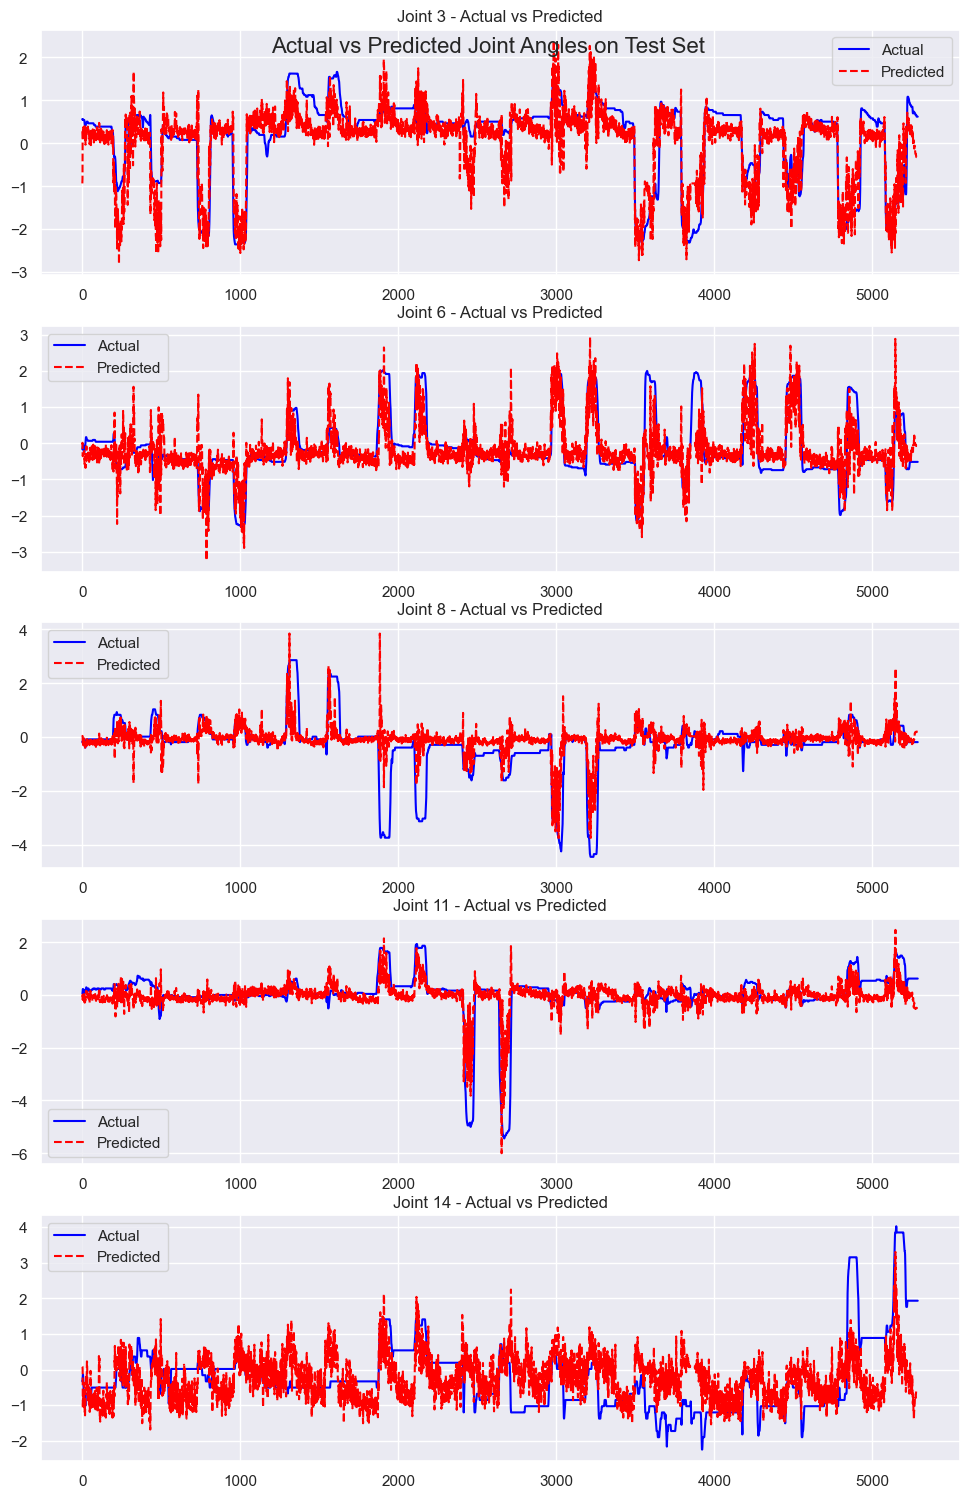

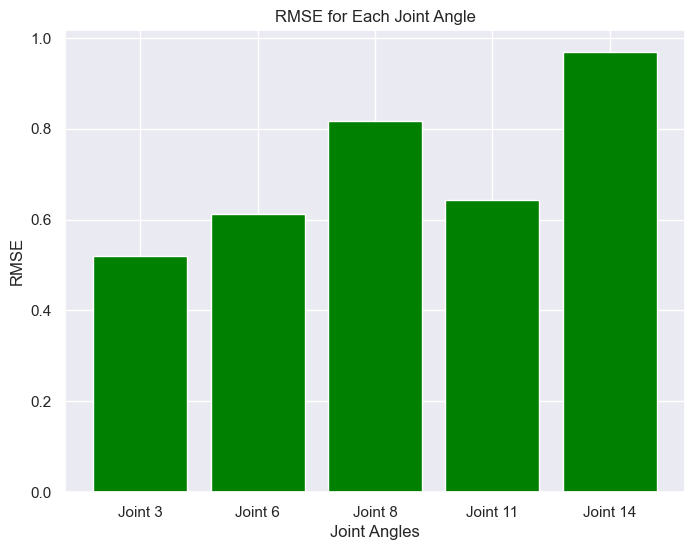

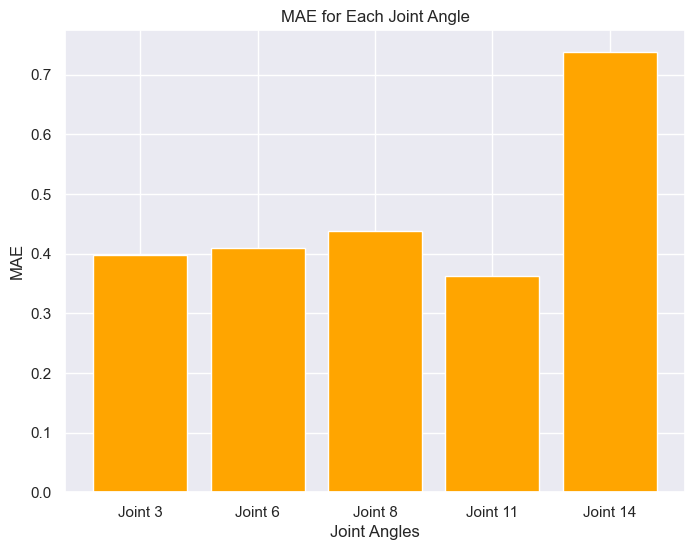

RMSE on Validation Set:
[0.58667465 0.69106205 0.86502529 0.74257776 1.07984707]
RMSE on Test Set:
[0.52073693 0.61216831 0.81788188 0.64199971 0.9683775 ]
MAE on Test Set:
[0.39837104 0.40915142 0.43845723 0.36159351 0.73768642]
The performance across joint angles is not stable, there may be some joint angles that are harder to predict.


In [83]:
# Visualize Actual vs Predicted for Each Joint Angle (on Test Set)
joint_angles = ['Joint 3', 'Joint 6', 'Joint 8', 'Joint 11', 'Joint 14']
fig, ax = plt.subplots(5, 1, figsize=(10, 15))
fig.tight_layout()
fig.suptitle("Actual vs Predicted Joint Angles on Test Set", fontsize=16)

for idx, joint in enumerate(joint_angles):
    ax[idx].plot(Labels_test_scaled[:, idx], label="Actual", color="blue")
    ax[idx].plot(y_pred_test_scaled[:, idx], linestyle="--", label="Predicted", color="red")
    ax[idx].set_title(f"{joint} - Actual vs Predicted")
    ax[idx].legend()

plt.show()

# Plot RMSE for Each Joint Angle
plt.figure(figsize=(8, 6))
plt.bar(joint_angles, rmse_test, color='green')
plt.title("RMSE for Each Joint Angle")
plt.ylabel("RMSE")
plt.xlabel("Joint Angles")
plt.show()

# Plot MAE for Each Joint Angle
plt.figure(figsize=(8, 6))
plt.bar(joint_angles, mae_test, color='orange')
plt.title("MAE for Each Joint Angle")
plt.ylabel("MAE")
plt.xlabel("Joint Angles")
plt.show()

# Performance Summary
print("RMSE on Validation Set:")
print(rmse_val)

print("RMSE on Test Set:")
print(rmse_test)

print("MAE on Test Set:")
print(mae_test)

# Check stability of the regression performance across joint angles
# Here, we want to see if there's a significant difference in RMSE and MAE between different joints
if np.max(rmse_test) - np.min(rmse_test) > 0.1:
    print("The performance across joint angles is not stable, there may be some joint angles that are harder to predict.")
else:
    print("The regression performance is stable across the joint angles.")


# GridSearch

This grid search does not yield better results, but due to computational cost concerns, we did not perform a more extensive one.

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best parameters: {'estimator__C': 0.1, 'estimator__epsilon': 0.1, 'estimator__kernel': 'rbf'}
Validation RMSE for each joint angle: [ 5.12675269 12.84329532  4.48983279  8.47220834  2.27039235]
Test RMSE for each joint angle: [ 4.5167963  11.48191472  4.34179773  6.8920373   1.9958113 ]
Test MAE for each joint angle: [3.43432926 7.7069632  2.3012174  3.22040296 1.49715674]


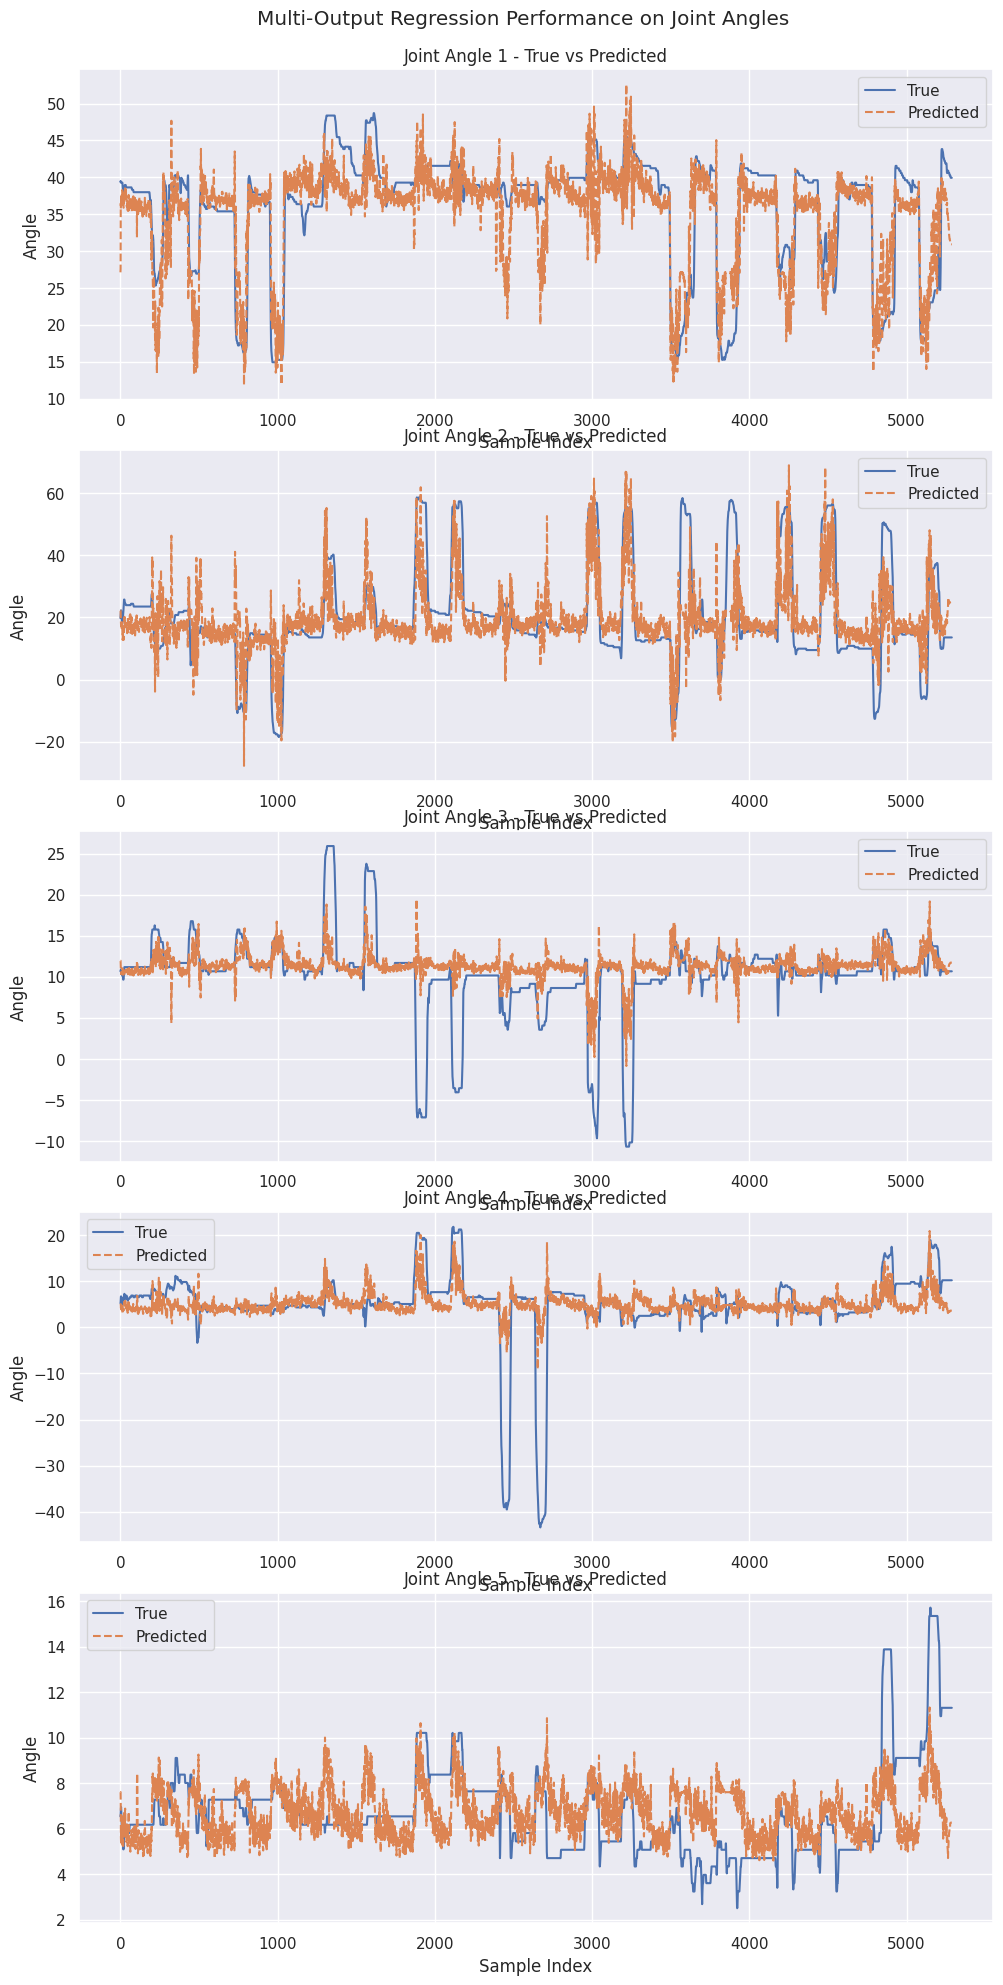

In [28]:
# Initialize scalers for EMG features and labels
scaler_emg = StandardScaler()
scaler_labels = StandardScaler()

# Normalize the EMG features (train, validation, and test)
EMG_train_normalized = scaler_emg.fit_transform(EMG_train_extracted_features)
EMG_val_normalized = scaler_emg.transform(EMG_val_extracted_features)
EMG_test_normalized = scaler_emg.transform(EMG_test_extracted_features)

# Normalize the labels (train, validation, and test)
Labels_train_normalized = scaler_labels.fit_transform(Labels_train_mean)
Labels_val_normalized = scaler_labels.transform(Labels_val_mean)
Labels_test_normalized = scaler_labels.transform(Labels_test_mean)

# Define the SVR model and hyperparameter grid
svr = SVR()
param_grid = {
    'estimator__C': [0.1, 1, 10],
    'estimator__epsilon': [0.01, 0.1],
    'estimator__kernel': ['rbf']
}

#
multi_output_svr = MultiOutputRegressor(svr)

# Perform grid search with normalized training data
grid_search = GridSearchCV(
    multi_output_svr,
    param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=2,
    n_jobs=-1
)

# Fit the model using grid search
grid_search.fit(EMG_train_normalized, Labels_train_normalized)

# Retrieve the best model
best_model = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)

# Make predictions on validation and test sets using the best model
y_pred_val_normalized = best_model.predict(EMG_val_normalized)
y_pred_test_normalized = best_model.predict(EMG_test_normalized)

# Inverse transform predictions and true labels to their original scale
y_pred_val = scaler_labels.inverse_transform(y_pred_val_normalized)
y_pred_test = scaler_labels.inverse_transform(y_pred_test_normalized)

# Calculate performance metrics on the original scale
rmse_val = np.sqrt(mean_squared_error(Labels_val_mean, y_pred_val, multioutput='raw_values'))
rmse_test = np.sqrt(mean_squared_error(Labels_test_mean, y_pred_test, multioutput='raw_values'))
mae_test = mean_absolute_error(Labels_test_mean, y_pred_test, multioutput='raw_values')

print("Validation RMSE for each joint angle:", rmse_val)
print("Test RMSE for each joint angle:", rmse_test)
print("Test MAE for each joint angle:", mae_test)

# Visualize predictions vs. true labels for test set
plt.close("all")
fig, axes = plt.subplots(len(Labels_train_mean[0]), 1, figsize=(10, 20))
fig.tight_layout()
fig.subplots_adjust(top=0.95)
fig.suptitle("Multi-Output Regression Performance on Joint Angles")

# Plot each joint angle separately
for i in range(len(Labels_train_mean[0])):
    axes[i].plot(Labels_test_mean[:, i], label="True")
    axes[i].plot(y_pred_test[:, i], linestyle="--", label="Predicted")
    axes[i].set_title(f"Joint Angle {i+1} - True vs Predicted")
    axes[i].legend()
    axes[i].set_xlabel("Sample Index")
    axes[i].set_ylabel("Angle")

plt.show()
